In [1]:
import geopandas as gpd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as pl
import os
from IPython import display
from subprocess import call
from fbprophet import Prophet

In [2]:
gdf = gpd.read_file('../data/shapefile/DRC-healthzones/zone_stc_puc.shp')
evd_df = pd.read_csv('../data/ebola_drc/drc/data.csv').fillna(0)
## removing first row, corresponding to pre-epidemic cases
evd_df = evd_df[1:]
evd_df = evd_df[evd_df.health_zone!='Ntondo'] ## Currently no cases
evd_df['Date'] = evd_df.report_date.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
evd_df['all_cases'] = evd_df.confirmed_cases + evd_df.probable_cases + evd_df.suspect_cases

INFO:Fiona:Failed to auto identify EPSG: 7


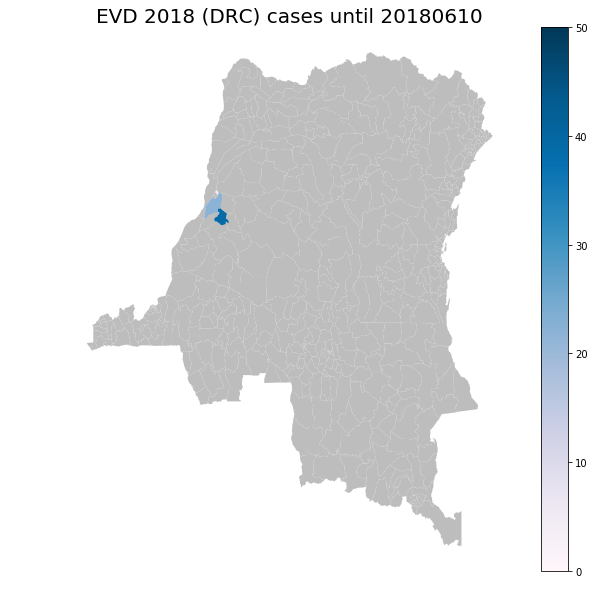

In [4]:
count = 0
for rd in evd_df.report_date.unique():
    f = plt.figure(figsize=(10,10))
    ax = plt.gca()
    plt.axis('off')
    plt.title('EVD 2018 (DRC) cases until {}'.format(rd),fontsize=20)
    gdf.plot(color='#bdbdbd',ax=ax)
    df = evd_df[evd_df.report_date==rd]
    temp_gdf = gdf.merge(df,left_on='NOM_ZS',right_on='health_zone',how='inner')
    temp_gdf.plot(ax=ax,column='all_cases',cmap='PuBu',vmin=0,vmax=50,legend=True)
    display.clear_output(wait=True)
    display.display(pl.gcf())    
    plt.savefig('../plots/{:02d}.png'.format(count),bbox_inches='tight')
    count+=1
    plt.close()
call("convert -delay 200 -loop 1 ../plots/*.png ../plots/animated_DRC.gif".split(' '))
[os.remove('../plots/'+x) for x in os.listdir('../plots') if '.png' in x];

In [5]:
zs_list = evd_df.health_zone.unique()
prov_list = gdf[gdf.NOM_ZS.isin(zs_list)]['PROVINCE'].unique()
print prov_list

[u'Equateur']


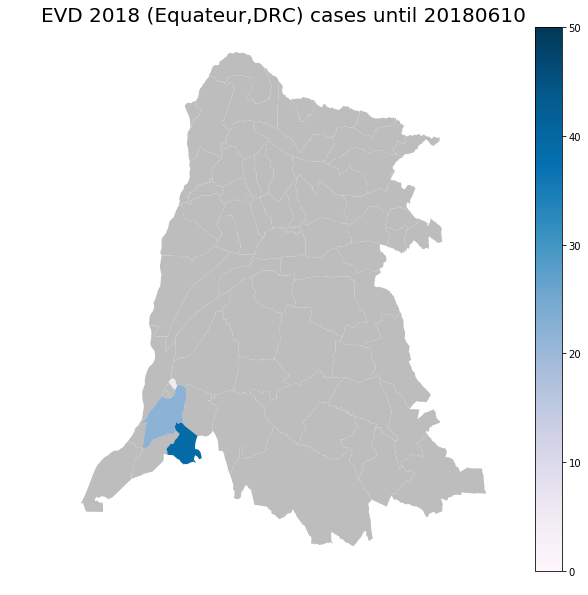

In [6]:
count = 0
mask = gdf.PROVINCE.isin(prov_list)
for rd in evd_df.report_date.unique():
    f = plt.figure(figsize=(10,10))
    ax = plt.gca()
    plt.axis('off')
    plt.title('EVD 2018 (Equateur,DRC) cases until {}'.format(rd),fontsize=20)
    gdf[mask].plot(color='#bdbdbd',ax=ax)
    df = evd_df[evd_df.report_date==rd]
    temp_gdf = gdf.merge(df,left_on='NOM_ZS',right_on='health_zone',how='inner')
    temp_gdf.plot(ax=ax,column='all_cases',cmap='PuBu',vmin=0,vmax=50,legend=True)
    display.clear_output(wait=True)
    display.display(pl.gcf())    
    plt.savefig('../plots/{:02d}.png'.format(count),bbox_inches='tight')
    count+=1
    plt.close()
call("convert -delay 200 -loop 1 ../plots/*.png ../plots/animated_Equateur.gif".split(' '))
[os.remove('../plots/'+x) for x in os.listdir('../plots') if '.png' in x];

### Plotting Cumulative cases epicurves as reported

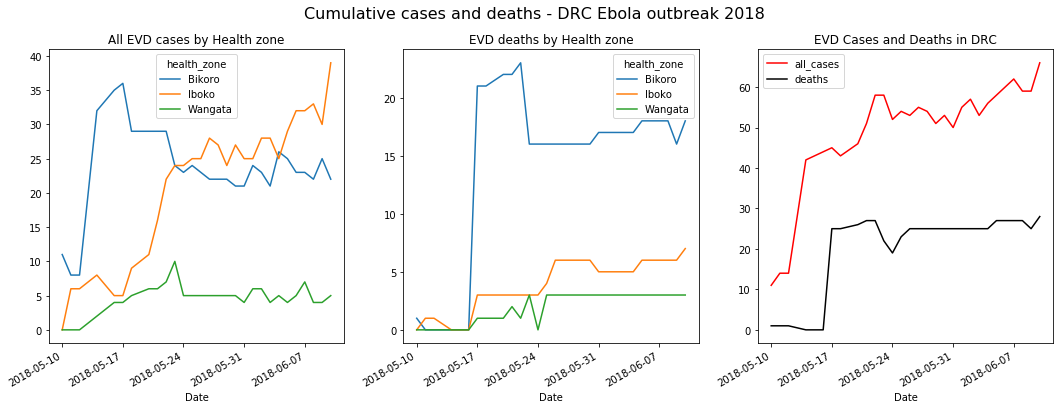

In [7]:
f,axarr = plt.subplots(1,3,figsize=(18,6))
evd_df.pivot(index='Date',columns='health_zone',values='all_cases').fillna(0).plot(ax=axarr[0])
#axarr[0].text(0.15, -0.04, '* confirmed, suspected and probable', transform=ax.transAxes)

evd_df.pivot(index='Date',columns='health_zone',values='deaths').fillna(0).plot(ax=axarr[1])
evd_df.groupby(['Date'])[['all_cases','deaths']].sum().plot(ax=axarr[2],color=['red','black'])

axarr[0].set_title('All EVD cases by Health zone')
axarr[1].set_title('EVD deaths by Health zone')
axarr[2].set_title('EVD Cases and Deaths in DRC')
plt.suptitle('Cumulative cases and deaths - DRC Ebola outbreak 2018',fontsize=16)
plt.savefig('../plots/DRC_EVD_epicurves.jpg',dpi=100, bbox_inches='tight')

In [58]:
x = evd_df[evd_df.health_zone=='Wangata']['all_cases'].values
x[-1] - x[-14]

0.0

### Vaccinations plot

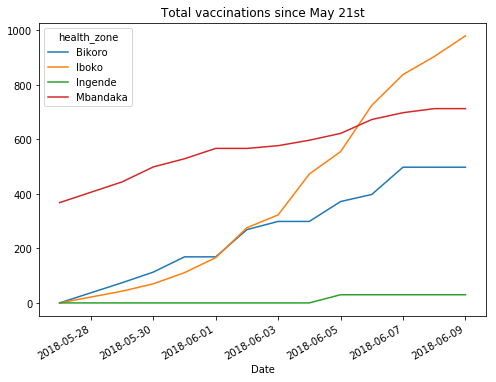

In [8]:
vax_df = pd.read_csv('../data/vax/vax_data.csv')
vax_df['Date'] = vax_df.event_date.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))

f = plt.figure(figsize=(8,6))
ax = plt.gca()
vax_df.pivot(index='Date',columns='health_zone',values='total_vaccinated').fillna(0).plot(ax=ax)
plt.title('Total vaccinations since May 21st')
plt.savefig('../plots/DRC_EVD_vax.jpg',dpi=100,bbox_inches='tight')

In [41]:
df = evd_df.groupby(['Date']).sum()['all_cases'].reset_index()
df.columns = ['ds','y']
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=30)
future.tail()
forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 22.0.


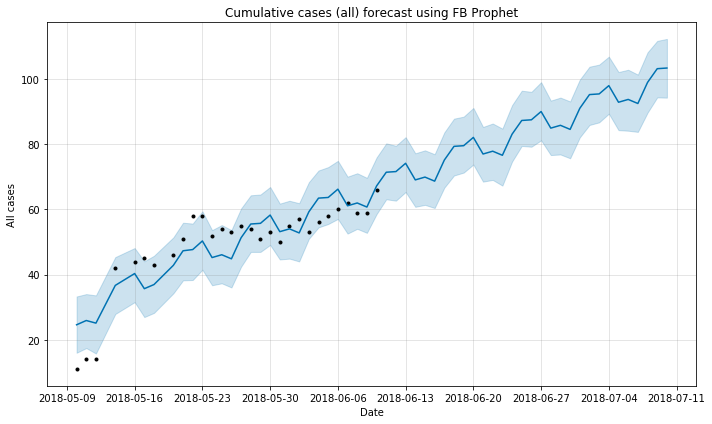

In [42]:
m.plot(forecast);
plt.title('Cumulative cases (all) forecast using FB Prophet')
plt.ylabel('All cases')
plt.xlabel('Date')
plt.tight_layout()
#plt.savefig('../plots/prophet_DRC.jpg',dpi=100,bbox_inches='tight')

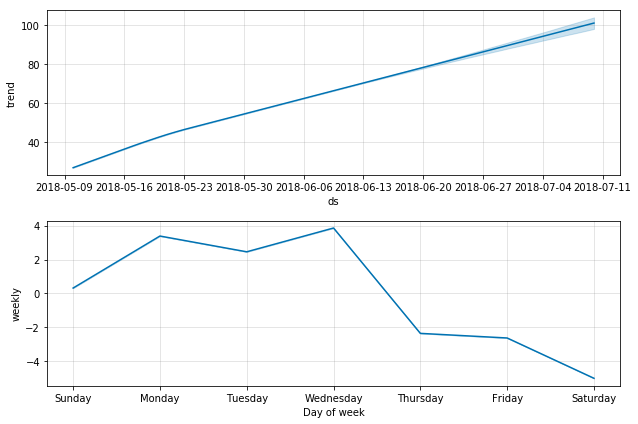

In [44]:
m.plot_components(forecast);